# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [5]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

Default GPU Device: /device:GPU:0


In [6]:
def download_file(url, file_path):
    import requests
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt

download_file(f'https://github.com/UofT-DSI/deep_learning/raw/main/assignments/downloaded_books/' + dataset, dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.1)

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [7]:
# Your code here
# Print the first 1000 characters of the dataset
print("First 1000 characters of the dataset:")
print(text[:1000])

# Report the dataset's size
dataset_size = len(text)
print(f"\nDataset size: {dataset_size} characters")

# Count the number of unique characters
unique_chars = sorted(set(text))  # Get unique characters
num_unique_chars = len(unique_chars)
print(f"Number of unique characters: {num_unique_chars}")

# Print the unique characters (optional)
print("\nUnique characters:")
print(unique_chars)

First 1000 characters of the dataset:








<!DOCTYPE html>
<html
  lang="en"
  
  data-color-mode="auto" data-light-theme="light" data-dark-theme="dark"
  data-a11y-animated-images="system" data-a11y-link-underlines="true"
  
  >



  <head>
    <meta charset="utf-8">
  <link rel="dns-prefetch" href="https://github.githubassets.com">
  <link rel="dns-prefetch" href="https://avatars.githubusercontent.com">
  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">
  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">
  <link rel="preconnect" href="https://github.githubassets.com" crossorigin>
  <link rel="preconnect" href="https://avatars.githubusercontent.com">

      <link rel="preload" href="https://github.githubassets.com/assets/global-banner-disable-f988792be49f.js" as="script" crossorigin>

  <link rel="preload" href="https://github.githubassets.com/assets/mona-sans-d1bf285e9b9b.woff2" as="font" type="font/woff2" crossorigin>


  <link cros

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Convert the entire text to lowercase
text = text.lower()

# Define vocabulary size and OOV token
VOCAB_SIZE = 10000  # Adjust this based on your dataset size and requirements
OOV_TOKEN = "<OOV>"  # Token to represent out-of-vocabulary words

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

# Fit the tokenizer on the text
tokenizer.fit_on_texts([text])

# Convert the text to sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0]

# Print some information
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"OOV token: {OOV_TOKEN}")
print(f"First 10 sequences: {sequences[:10]}")
print(f"Word index (first 10 items): {list(tokenizer.word_index.items())[:10]}")

Vocabulary size: 10000
OOV token: <OOV>
First 10 sequences: [382, 115, 115, 383, 240, 15, 39, 241, 93, 15]
Word index (first 10 items): [('<OOV>', 1), ('github', 2), ('com', 3), ('script', 4), ('https', 5), ('1', 6), ('defer', 7), ('js', 8), ('assets', 9), ('githubassets', 10)]


*If* everything worked, the following line should show you the first 10 words in the vocabulary:

In [9]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('github', 2), ('com', 3), ('script', 4), ('https', 5), ('1', 6), ('defer', 7), ('js', 8), ('assets', 9), ('githubassets', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [11]:
import numpy as np  # Add this import statement at the top of your script

# Define sequence length
SEQ_LENGTH = 50  # Adjust this based on your dataset and requirements

# Convert the text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0]

# Generate the training sequences
X = []
y = []
for i in range(SEQ_LENGTH, len(sequences)):
    # Extract a sequence of SEQ_LENGTH tokens
    input_sequence = sequences[i-SEQ_LENGTH:i]
    # The target is the next token after the sequence
    target_token = sequences[i]
    # Append to X and y
    X.append(input_sequence)
    y.append(target_token)

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Print some information
print(f"Total training sequences: {len(X)}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"First input sequence: {X[0]}")
print(f"First target token: {y[0]}")

Total training sequences: 3819
Shape of X: (3819, 50)
Shape of y: (3819,)
First input sequence: [382 115 115 383 240  15  39 241  93  15  55  57  55  15  53  57  53  15
 183 384 242 243  15 183  20 385  43 244  14 386 387 245  20  29 138 139
  25   5   2  10   3  20  29 138 139  25   5 246 184   3]
First target token: 20


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [12]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [382 115 115 383 240  15  39 241  93  15  55  57  55  15  53  57  53  15
 183 384 242 243  15 183  20 385  43 244  14 386 387 245  20  29 138 139
  25   5   2  10   3  20  29 138 139  25   5 246 184   3]
Target: 20
Translated back to words: ['doctype', 'html', 'html', 'lang', 'en', 'data', 'color', 'mode', 'auto', 'data', 'light', 'theme', 'light', 'data', 'dark', 'theme', 'dark', 'data', 'a11y', 'animated', 'images', 'system', 'data', 'a11y', 'link', 'underlines', 'true', 'head', 'meta', 'charset', 'utf', '8', 'link', 'rel', 'dns', 'prefetch', 'href', 'https', 'github', 'githubassets', 'com', 'link', 'rel', 'dns', 'prefetch', 'href', 'https', 'avatars', 'githubusercontent', 'com'] -> link


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [13]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (3055, 50)
y_train shape: (3055, 10000)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Define model
model = Sequential([
    # Embedding layer: Maps input words (tokens) into dense vectors
    Embedding(input_dim=VOCAB_SIZE, output_dim=100, input_length=SEQ_LENGTH),

    # LSTM layer: Captures sequential patterns in text
    LSTM(128, return_sequences=True),
    LSTM(128),

    # Fully connected layer
    Dense(128, activation='relu'),

    # Output layer with softmax to predict the next word
    Dense(VOCAB_SIZE, activation='softmax')
])

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=100, input_length=SEQ_LENGTH),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(128, activation='relu'),
    Dense(VOCAB_SIZE, activation='softmax')
])

# Build the model by explicitly defining input shape
model.build(input_shape=(None, SEQ_LENGTH))
model.summary()

# Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 50, 100)             │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 50, 128)             │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10000)               │       1,290,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,555,344 (9.75 MB)

 Trainable params: 2,555,344 (9.75 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 50, 100)             │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 50, 128)             │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10000)               │       1,290,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,555,344 (9.75 MB)

 Trainable params: 2,555,344 (9.75 MB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

In [16]:
# Your code here
from keras.optimizers import Adam

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Print summary to confirm
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 50, 100)             │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 50, 128)             │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10000)               │       1,290,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,555,344 (9.75 MB)

 Trainable params: 2,555,344 (9.75 MB)

 Non-trainable params: 0 (0.00 B)

## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [17]:
# Your code here
# Train the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=5,  # Number of epochs
    batch_size=128,  # Number of samples per batch
    validation_data=(X_val, y_val)  # Validation data
)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.0176 - loss: 8.9000 - val_accuracy: 0.0366 - val_loss: 6.3063
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0231 - loss: 6.0272 - val_accuracy: 0.0366 - val_loss: 6.1882
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0329 - loss: 5.6906 - val_accuracy: 0.0366 - val_loss: 6.1633
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0278 - loss: 5.6513 - val_accuracy: 0.0366 - val_loss: 6.1943
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0397 - loss: 5.6113 - val_accuracy: 0.0366 - val_loss: 6.2067


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

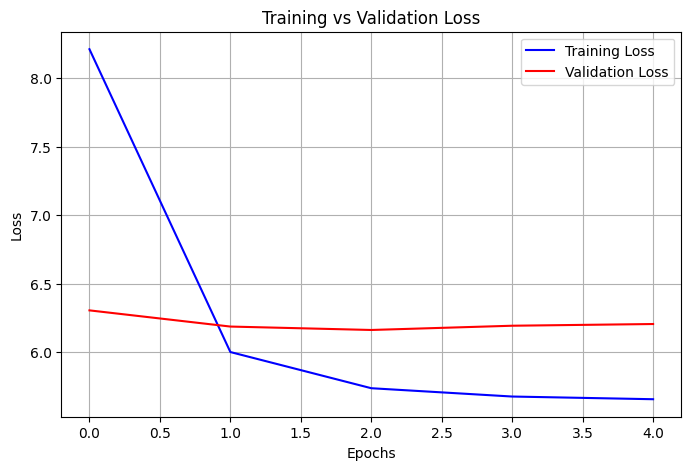

In [18]:
import matplotlib.pyplot as plt

# Your code here
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [19]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words=50):
    """
    Generate new text using the trained model.

    Parameters:
    - model: The trained RNN model.
    - tokenizer: The tokenizer used for text preprocessing.
    - seed_text: Initial text to start generation.
    - max_sequence_len: The maximum length of input sequences.
    - num_words: Number of words to generate.

    Returns:
    - Generated text as a string.
    """
    generated_text = seed_text

    for _ in range(num_words):
        # Tokenize the seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Pad sequence to match training input length
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')

        # Predict the next word (probability distribution over vocabulary)
        predicted_probs = model.predict(token_list, verbose=0)

        # Choose the word with the highest probability
        predicted_index = np.argmax(predicted_probs)

        # Convert the predicted token index back to a word
        predicted_word = tokenizer.index_word.get(predicted_index, '')

        # Stop if the word is unknown or empty (model limitation)
        if predicted_word == '':
            break

        # Append the predicted word to the generated text
        generated_text += ' ' + predicted_word

        # Update seed text for next iteration
        seed_text += ' ' + predicted_word

    return generated_text

In [20]:
# Test the text generation function
generated_text = generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)
print("Generated Text:\n", generated_text)

Generated Text:
 hamlet github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github github


It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small.

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras.
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [21]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2025-03-10 03:24:45--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.99MB/s    in 2m 56s  

2025-03-10 03:27:43 (4.67 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [22]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [23]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [24]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

In [25]:
# Define a new model and train it

# Your code here
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam

# Step 1: Load GloVe embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have downloaded it.")

# Step 2: Create embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, 100))  # 100 dimensions for GloVe 100d vectors
for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Step 3: Add an embedding layer to the model using the pre-trained embeddings
embedding_layer = Embedding(
    VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
)

# Step 4: Define a new model using the pre-trained embeddings
model = Sequential([
    embedding_layer,  # Use pre-trained embedding
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(128, activation='relu'),
    Dense(VOCAB_SIZE, activation='softmax')  # Output layer
])

# Compile the model with appropriate loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Step 5: Train the model with the data
history = model.fit(
    X_train, y_train,
    epochs=5,  # You can train for more epochs
    batch_size=128,
    validation_data=(X_val, y_val)
)


Found 400000 word vectors.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.0256 - loss: 8.7194 - val_accuracy: 0.0366 - val_loss: 6.3906
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0331 - loss: 6.0269 - val_accuracy: 0.0366 - val_loss: 6.1638
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0411 - loss: 5.6684 - val_accuracy: 0.0236 - val_loss: 6.1737
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0251 - loss: 5.6507 - val_accuracy: 0.0366 - val_loss: 6.1993
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0372 - loss: 5.6120 - val_accuracy: 0.0366 - val_loss: 6.2163


## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.